# Hearbeat dataset


## Data and Context

Nous avons acces à deux bases de données représentant un signal d'électorcardiogramme. La première base de données inclue un label avec 5 classes. la deuxième base n'inclue que 2 classes.

### Dataset 1 Classes:
(from https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm#annotations)

 - 0 -> 'N' : Normal beat
 - 1 -> 'S' : Supraventricular premature beat
 - 2 -> 'V' : Premature ventricular contraction
 - 3 -> 'F' : Fusion of ventricular and normal beat
 - 4 -> 'Q' : Unclassifiable beat
 
### Dataset 2 Classes:
 - 0 -> Normal beat
 - 1 -> Abnormal beat : myocardial infarction

### Objectif

l'objectif n'est pas clair puisque nous avons deux classification différentes. Nous pouvons transformer les labels de la première classe en Normal/Anormal/Inclassificables et y joindre le deuxième data set.

Nous pouvons aussi ajouter les classes normales du dataset 2 au dataset1 ou n'utiliser que le dataset 1 puis voir ce que cela donne sur le dataset 2

L'objectif serait de déterminer d'après un signal si un patient est attent d'arythmie au pas, c'est à dire si son ECG est normal ou pas.
puisqu'il existe un dataset test sur le jeu de données à 5 classes, il faudrait faire un modèle à tester sur ce fichier et donc augmenter le dataset avec celui à deux classes. on pourrait donc ajouter au dataset les "meilleurs" signaux du dataset 2. (par crosscor ou similarité en distance)
### Methodologie

Il est conseillé d'utiliser un model Deep Learning sur ces données. Ceci à on sens consisite en en réseau de neurones convolutifs 1D

### synthèse exploiratoire 
Nous allons voir que:
* ces données sont homogènes, chaque signal compte 187 échantillons pour les deux bases de données.
* la base de données n'est pas homogène en nombre de signaux par classe. Nous pouvons déjà conclure que l'on devra:
    * réchantionner la base
    * augmenter les classes faibles
    * il y a des signaux très courts, labelisés ce qui est très suprenant 

## Chargement des données

les données sont copiées dans data/raw mais ne sont pas envoyées sur le repository github

In [2]:
folder = '../data/raw'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy import signal



reading

In [4]:
df1 = pd.read_csv(os.path.join(folder,'mitbih_train.csv'),header=None)
target1 = df1.pop(187)
dict_target1 = {0: 'Normal',
               1:'Supraventricular premature beat',
               2:'Premature ventricular contraction',
               3:'Fusion of ventricular and normal beat',
              4: 'Unclassifiable beat'}
target_str1 = target1.replace(dict_target1)

df_b1 = pd.read_csv(os.path.join(folder,'ptbdb_abnormal.csv'),header=None)
df_b2 = pd.read_csv(os.path.join(folder,'ptbdb_normal.csv'),header=None)

df2 = pd.concat((df_b1,df_b2),axis=0)
target2 = df2.pop(187)
dict_target2 = {0: 'Normal',
               1:'Abnormal'}
target_str2 = target2.replace(dict_target2)

Fs = 125 # echantillonage à 125 Hz

### Distibutions des classes

C:\Users\passage\AppData\Local\Temp\ipykernel_18184\1487000811.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_str1,ax=ax,palette='PuRd_r')
C:\Users\passage\AppData\Local\Temp\ipykernel_18184\1487000811.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_str2,ax=ax,palette='PuRd_r',order=['Normal','Abnormal'])


(0.0, 76094.55)

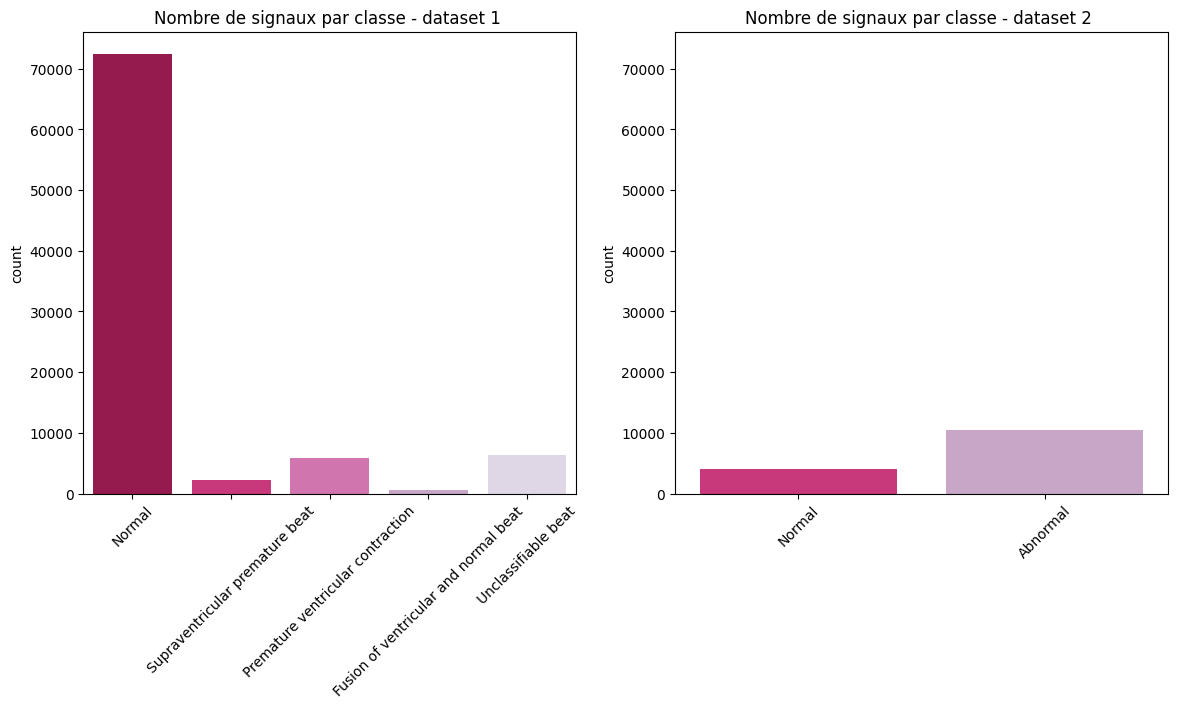

In [5]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
sns.countplot(x=target_str1,ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Nombre de signaux par classe - dataset 1 ')
ax.set_xlabel('')
l1 = ax.get_ylim()
ax = fig.add_subplot(122)
sns.countplot(x=target_str2,ax=ax,palette='PuRd_r',order=['Normal','Abnormal'])
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Nombre de signaux par classe - dataset 2 ');
ax.set_xlabel('')
ax.set_ylim(l1)

Nous avons donc une sur-représentation des données de type "normal" par rapport aux autres classes.

#### 1 dataset mergé

187
Normal                 76517
Abnormal               19158
Unclassifiable beat     6431
Name: count, dtype: int64


C:\Users\passage\AppData\Local\Temp\ipykernel_18184\3767816508.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=tagert_merge,ax=ax,palette='PuRd_r')


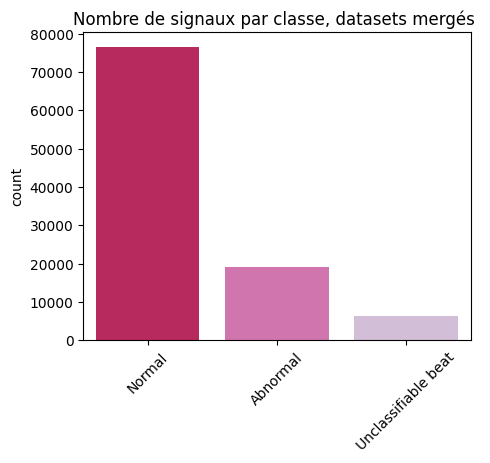

In [11]:
dict_target1_merge = {0: 'Normal',
               1:'Abnormal',
               2:'Abnormal',
               3:'Abnormal',
              4: 'Unclassifiable beat'}
target1_merge_str1= target1.replace(dict_target1_merge)

tagert_merge = pd.concat((target1_merge_str1,target_str2))
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot()
sns.countplot(x=tagert_merge,ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Nombre de signaux par classe, datasets mergés ')
ax.set_xlabel('')
print(tagert_merge.value_counts())

Nous avons environ 76000 signaux de types normaux, 19000 de types anormaux soit 4 fois moins et 6400 de type inclassificables. 
pour les deux jeux de données chque signal fait 187 échantillons (à 125 Hz cela fait 1.5s )

la variable cible a été extraire comme la dernière valeur de chauqe signal dans la base de départ.

### Amplitude des signaux

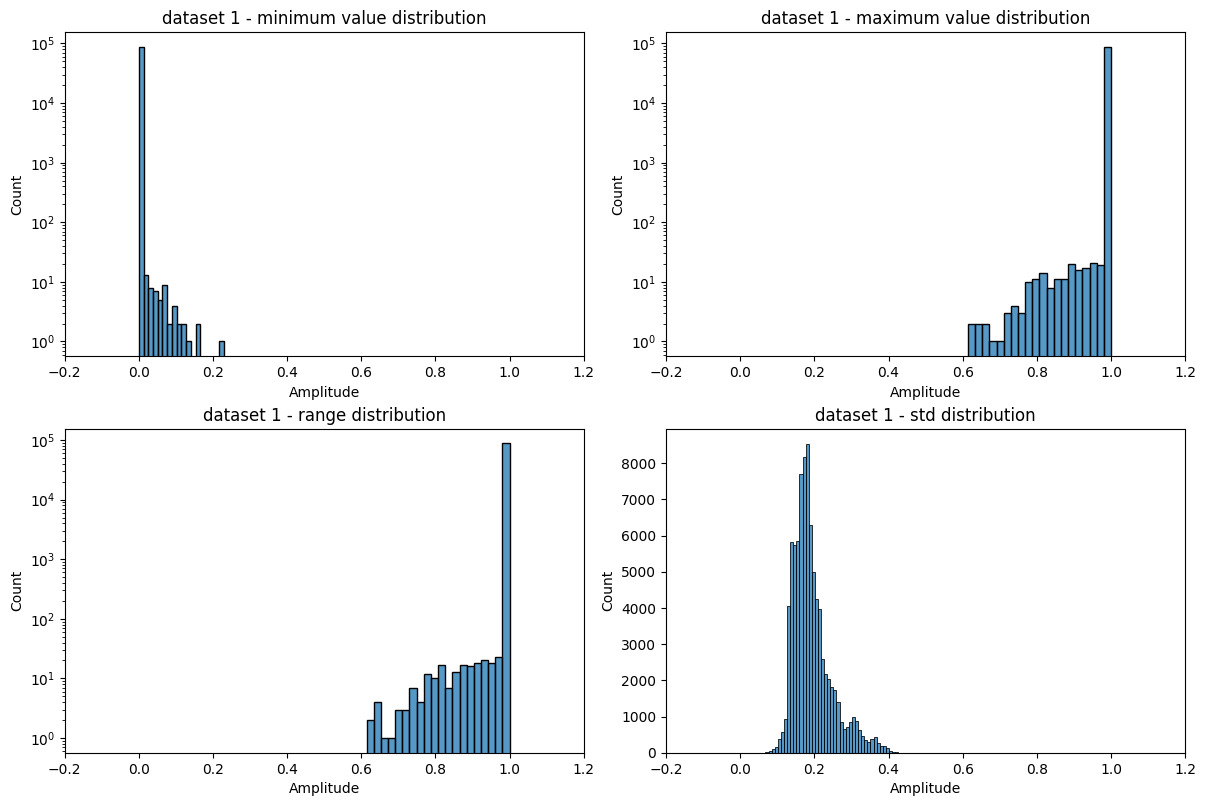

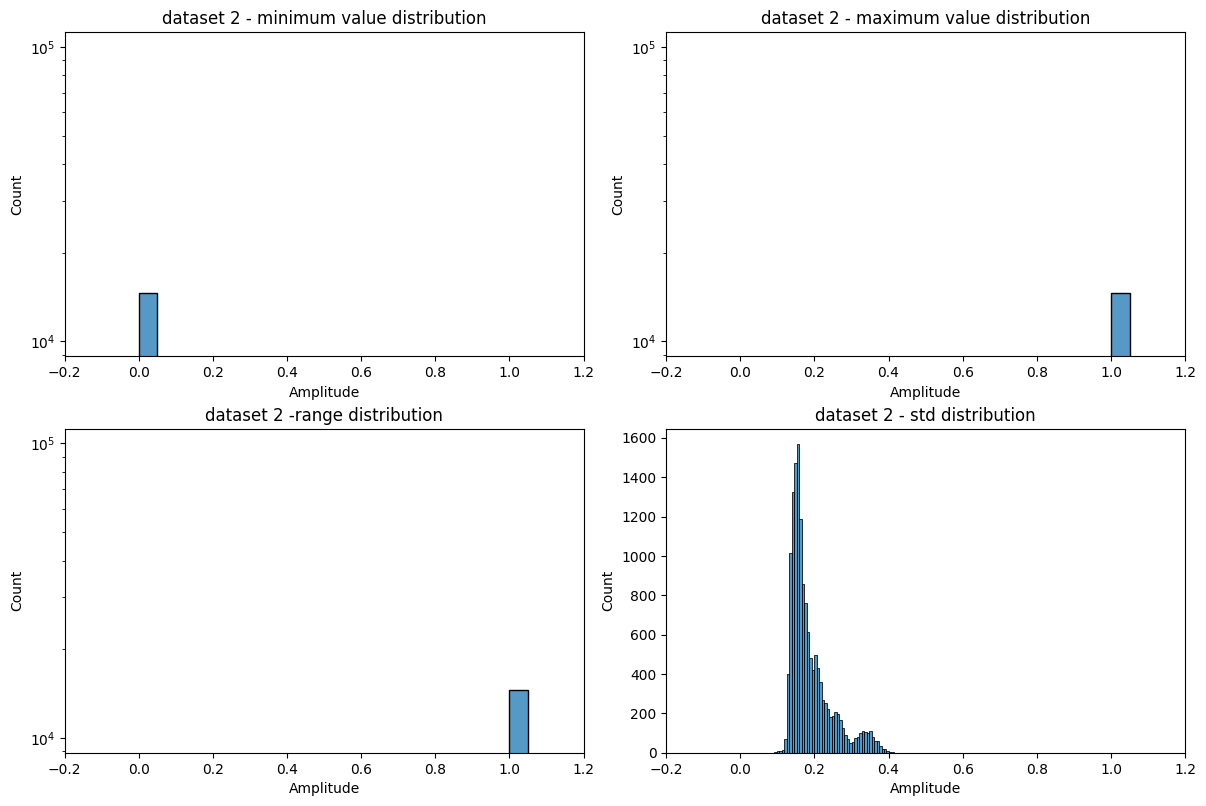

In [14]:
X1 = np.array(df1)
X2 = np.array(df2)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(221)
sns.histplot(x=np.min(X1,axis=1),ax=ax)
ax.set_title('dataset 1 - minimum value distribution')
ax.set_yscale('log')
ax.set_xlim([-0.2,1.2])
ax.set_xlabel('Amplitude')

ax = fig.add_subplot(222)
sns.histplot(x=np.max(X1,axis=1),ax=ax,bins=20)
ax.set_yscale('log')
ax.set_xlim([-0.2,1.2])
ax.set_title('dataset 1 - maximum value distribution')
ax.set_xlabel('Amplitude')

ax = fig.add_subplot(223)
sns.histplot(x=np.max(X1,axis=1)-np.min(X1,axis=1),ax=ax,bins=20)
ax.set_yscale('log')
ax.set_xlim([-0.2,1.2])
ax.set_title('dataset 1 - range distribution')
ax.set_xlabel('Amplitude')

ax = fig.add_subplot(224)
sns.histplot(x=np.std(X1,axis=1),ax=ax,bins=50)
ax.set_title('dataset 1 - std distribution')
ax.set_xlim([-0.2,1.2])
ax.set_xlabel('Amplitude')
fig.tight_layout(pad=0.5)

plt.show()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(221)
sns.histplot(x=np.min(X2,axis=1),ax=ax,bins=20)
ax.set_title('dataset 2 - minimum value distribution')
ax.set_yscale('log')
ax.set_xlim([-0.2,1.2])
ax.set_xlabel('Amplitude')


ax = fig.add_subplot(222)
sns.histplot(x=np.max(X2,axis=1),ax=ax,bins=20)
ax.set_yscale('log')
ax.set_title('dataset 2 - maximum value distribution')
ax.set_xlim([-0.2,1.2])
ax.set_xlabel('Amplitude')


ax = fig.add_subplot(223)
sns.histplot(x=np.max(X2,axis=1)-np.min(X2,axis=1),ax=ax,bins=20)
ax.set_yscale('log')
ax.set_title('dataset 2 -range distribution')
ax.set_xlim([-0.2,1.2])
ax.set_xlabel('Amplitude')


ax = fig.add_subplot(224)
sns.histplot(x=np.std(X2,axis=1),ax=ax,bins=50)
ax.set_title('dataset 2 - std distribution')
ax.set_xlim([-0.2,1.2])
ax.set_xlabel('Amplitude')
fig.tight_layout(pad=0.5)

Il n'y a aucune valeur manquante sur le dataset. les données sont entre 0 et 1. il n'y a pas besoin d'appliquer une nromalisation
la base 2 est encore mieux normalisée


## example de signaux

In [15]:
index_of_class_1 = {}
for k in range(5):
    index_of_class_1[k] =  [i for i, x in enumerate(target1==k) if x]
    
index_of_class_2 = {}
for k in range(1):
    index_of_class_2[k] =  [i for i, x in enumerate(target2==k) if x]
    
# fonction pour afficher des signaux 
def display_N_signals(X,N,list_of_index,ax=None):
    last_s = X.shape[1]
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    list_ii = np.random.choice(list_of_index,N)
    for kii,ii in enumerate(list_ii):
        ax.plot(X[ii,:]-np.mean(X[ii,:])+kii*0.75,color='k')
        ax.text(last_s,kii*0.75,ii)

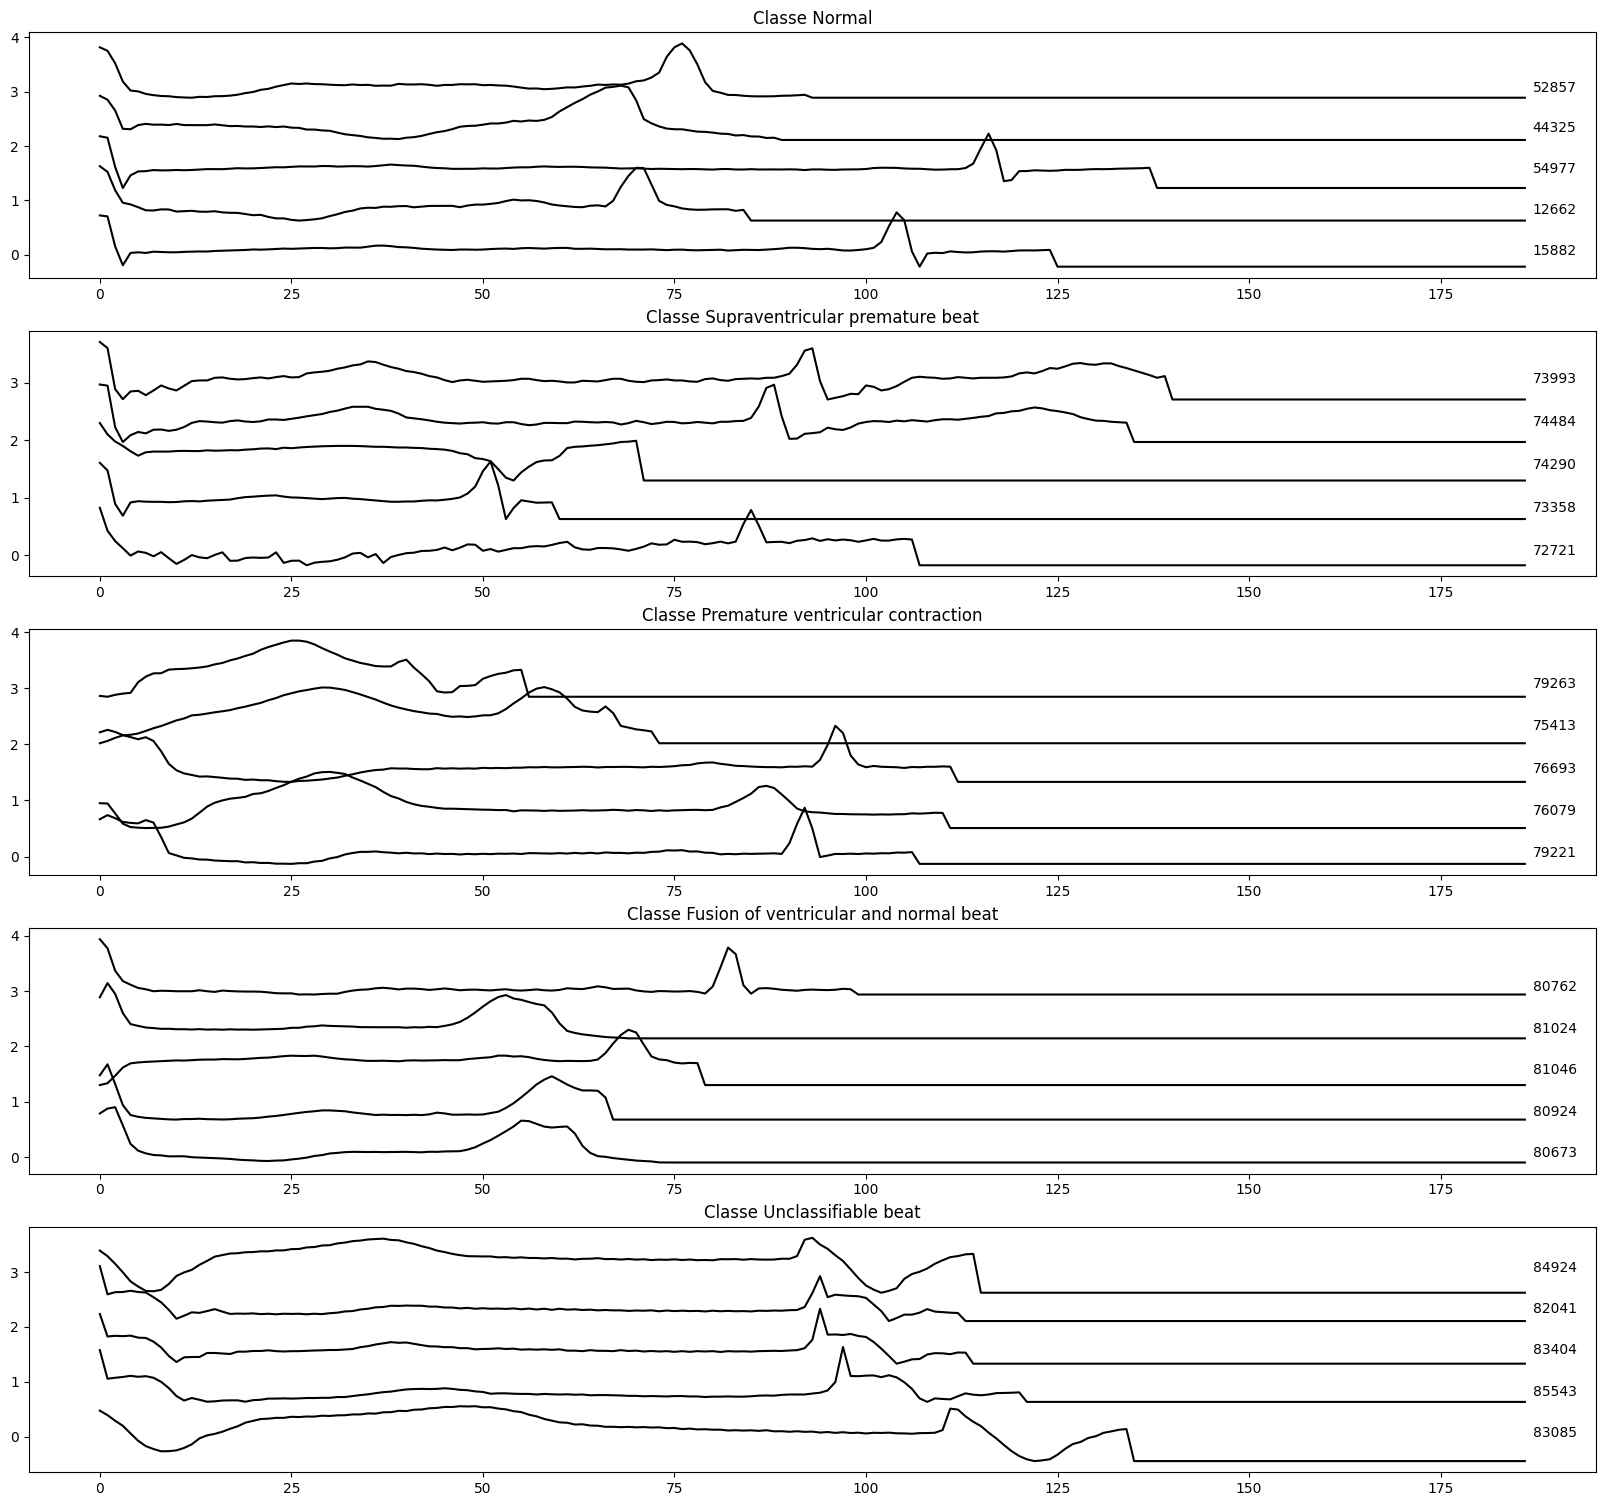

In [16]:
fig = plt.figure(figsize=(16,15))
for cl in range(5):
    
    ax = fig.add_subplot(511+cl)
    display_N_signals(X1,5,index_of_class_1[cl],ax=ax)
    ax.set_title('Classe ' + dict_target1[cl])
    
fig.tight_layout(pad=0.5)

## les signaux courts

In [18]:
def getdur(x):
    n_zeros_pad = np.argmax( np.flip(x)!=0)
    signal_dur_sample = -n_zeros_pad + 187
    return signal_dur_sample

In [19]:
Dur_1 = np.zeros(X1.shape[0])
for k in range(X1.shape[0]):
    Dur_1[k] = getdur(X1[k,:])
Dur_2 = np.zeros(X2.shape[0])
for k in range(X2.shape[0]):
    Dur_2[k] = getdur(X2[k,:])

C:\Users\passage\AppData\Local\Temp\ipykernel_18184\326632606.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_str1[Dur_1<n_short],palette='PuRd_r')


Text(0.5, 1.0, 'Nombre de signaux inférieurs à 50 échantillons')

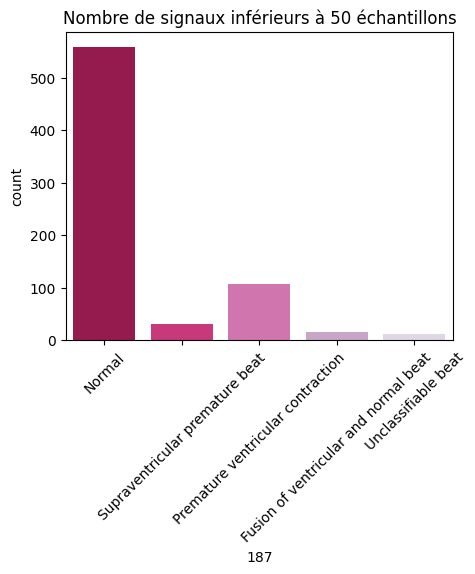

In [22]:
n_short = 50
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot()
sns.countplot(x=target_str1[Dur_1<n_short],palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Nombre de signaux inférieurs à %d échantillons' %n_short)


In [23]:
i_short_1 = Dur_1<n_short
i_short_2 = Dur_2<n_short
index_of_class_1_short = {}
for k in range(5):
    index_of_class_1_short[k] =  [i for i, x in enumerate(target1==k) if x and i_short_1[i]]
    
index_of_class_2_short = {}
for k in range(2):
    index_of_class_2_short[k] =  [i for i, x in enumerate(target2==k) if  x and i_short_2[i]]
    

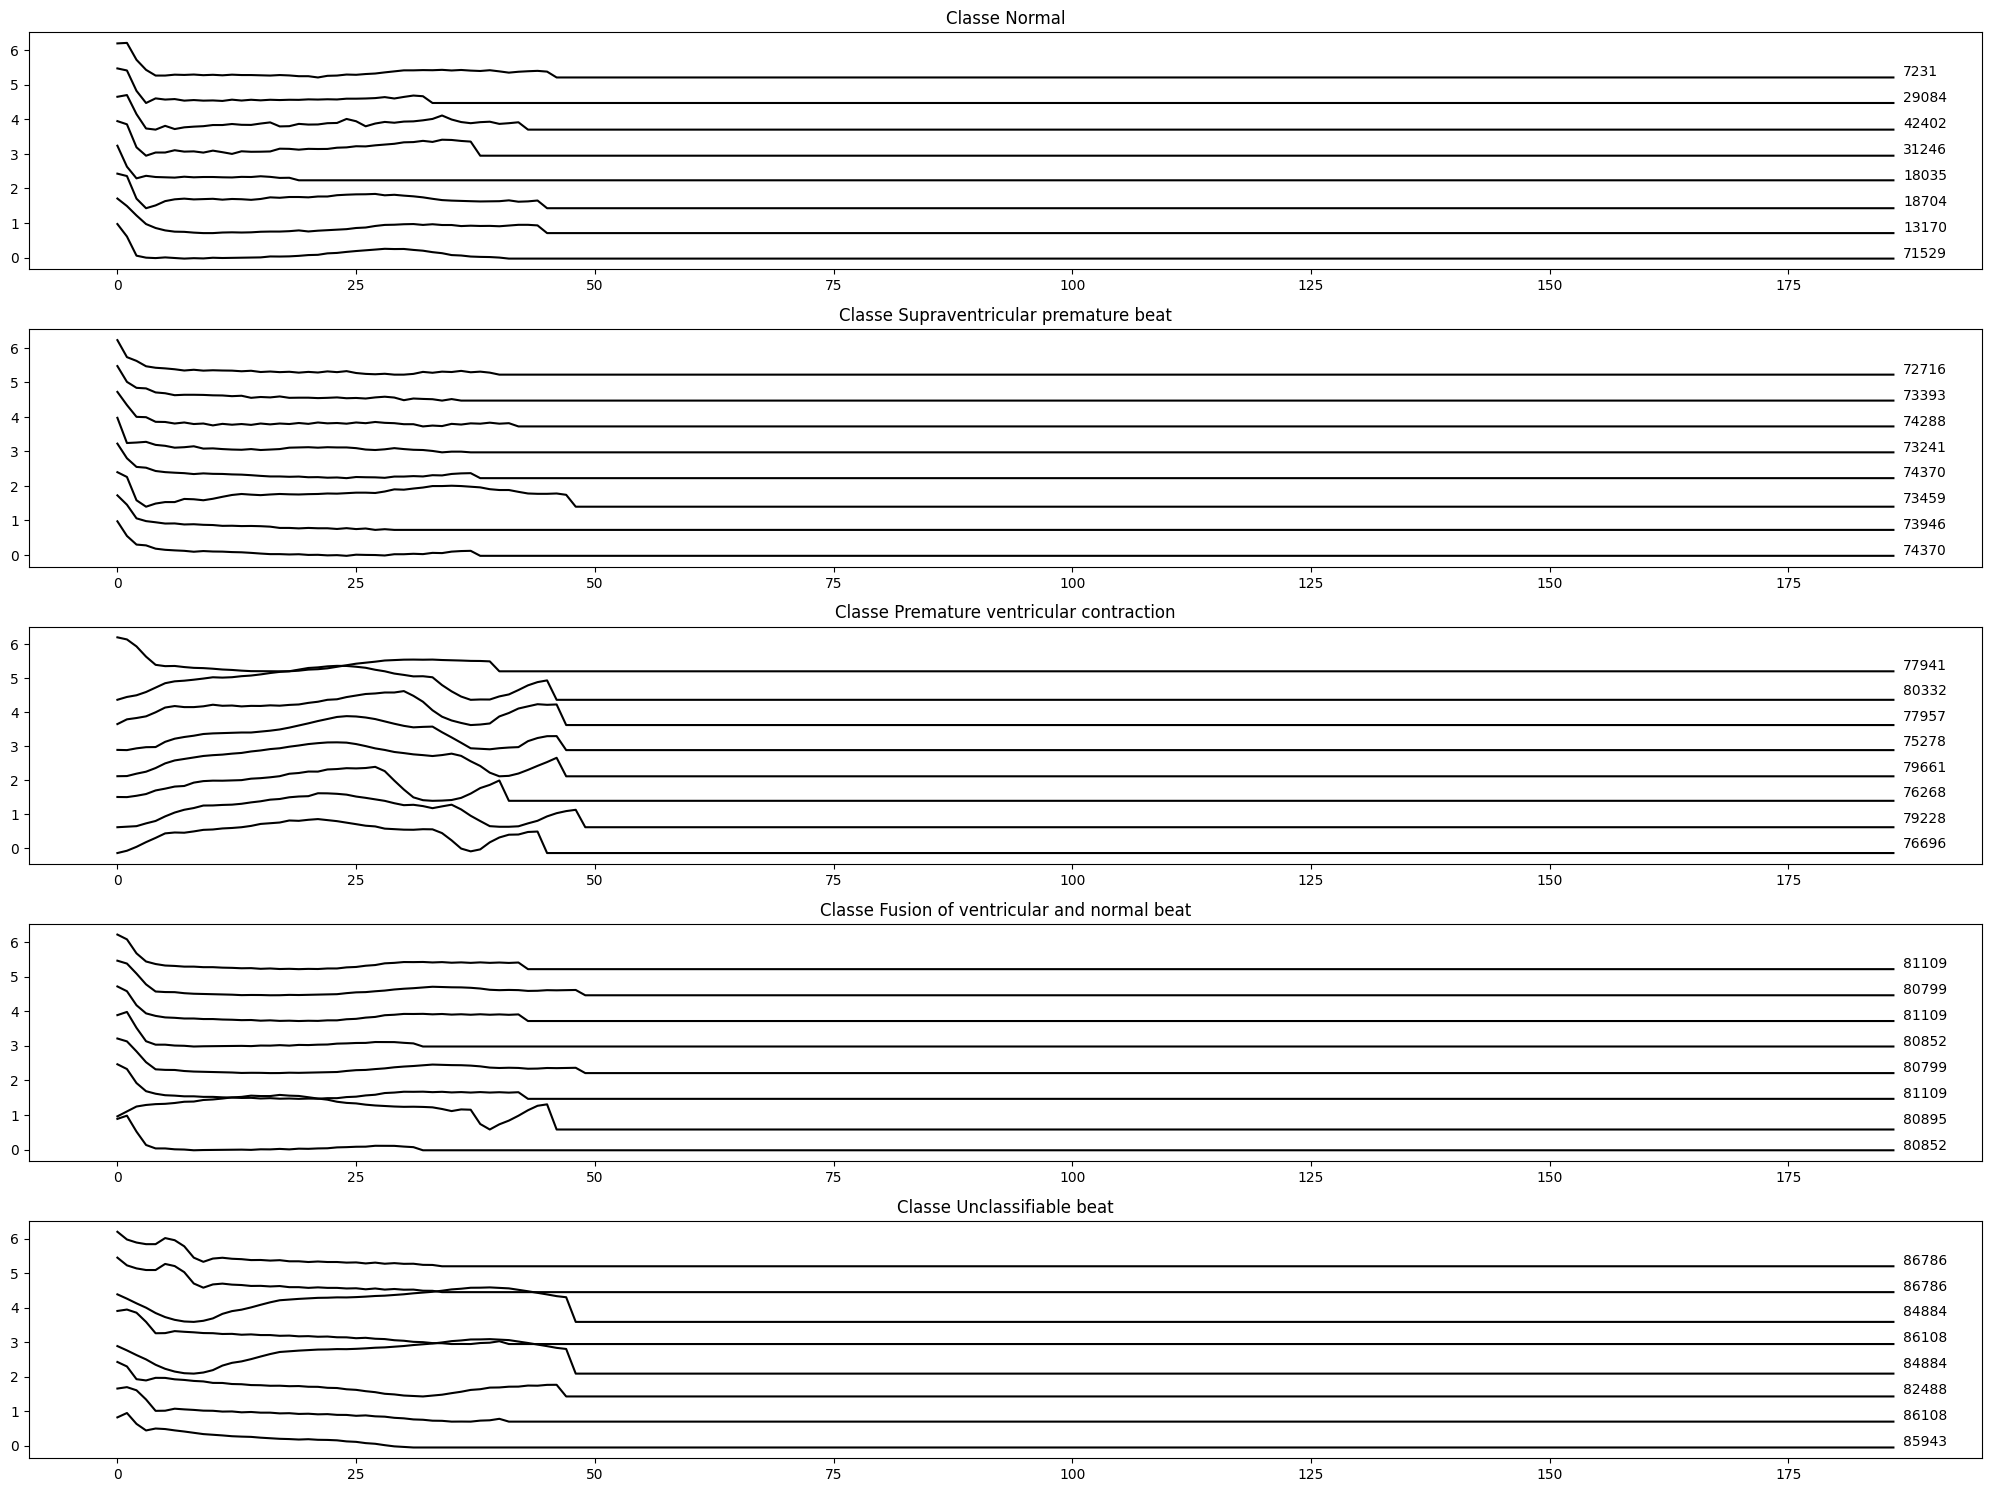

In [24]:

fig = plt.figure(figsize=(20,15))
for cl in range(5):
    
    ax = fig.add_subplot(511+cl)
    display_N_signals(X1,8,index_of_class_1_short[cl],ax=ax)
    ax.set_title('Classe ' + dict_target1[cl])

fig.tight_layout(pad=1)

## Conclusion

il n'y a pas forcément de nettoyage a faire pour un traitement DNN

il faudra voir si l'on passe par un DNN 1D ou un DNN 2D basé sur des spectrogrammes
 on pourra essayer de comparer avant avec un modèle non deep learingn basé sur des features
 
 il est assez compliqué pour le moment de voir une corrélation entre un signal et sa classe